# Imports

In [ ]:
#@title [Imports]
import numpy as np
from pprint import pprint
import os
import io
import warnings

#to amke this notebook's output stable across runs
np.random.seed(42)

#sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate, cross_val_predict, RandomizedSearchCV


#scipy
from scipy.stats import loguniform

#To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#global settings
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)
mpl.rc('figure',figsize=(8,6))

In [ ]:
#Ignore all warnings(convergence...) by sklearn
def warn(*args, **kwargs):
  pass
import warnings
warnings.warn = warn

#HandWritten digit Classification

In [ ]:
from sklearn.datasets import fetch_openml
X_pd,y_pd = fetch_openml('mnist_784',version=1,return_X_y=True)

In [ ]:
X=X_pd.to_numpy()
y=y_pd.to_numpy()

## Preprocessing
- Unlike p[erceptron whre scaling is optional, sigmoid requires scaling the feature range between 0 and 1
- **Do not apply** mean centering as it removes zeros from the data, however zeros should be zeros in the dataset
- Since we are using only one preprocessing step, using pipeline may not be required

In [ ]:
scaler = MinMaxScaler()
X=scaler.fit_transform(X)

In [ ]:
print("Mean of the faeture",np.mean(X))
print('Standard deviation',np.std(X))
print("Minimum value of X",np.min(X))
print("Maximum value of X",np.max(X))

Mean of the faeture 0.13092720382627604
Standard deviation 0.3084510570135976
Minimum value of X 0.0
Maximum value of X 1.0


In [ ]:
target_names = np.unique(y)
print('Number of samples {0} and type {1}'.format(X.shape[0],X.dtype))
print('Number of features:{0}'.format(X.shape[1]))
print('Number of classes: {0} and type:{1}'.format(len(target_names),y.dtype))
print('Labels:{0}'.format(target_names))

Number of samples 70000 and type float64
Number of features:784
Number of classes: 10 and type:object
Labels:['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## Data Visualization

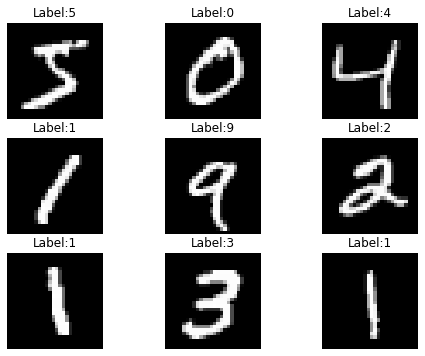

In [ ]:
num_images = 9 #choose a square number
factor = np.int(np.sqrt(num_images))
fig, ax =plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 #take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*factor
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

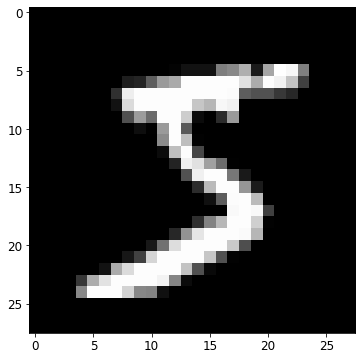

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(X[0].reshape(28,28),cmap='gray')
plt.show()

## Data Splitting

In [ ]:
x_train, x_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

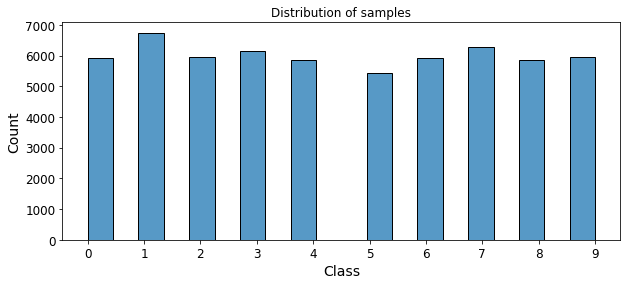

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

# Binary Classification : 0-Detector
Label '0' will be changed to 1 and all other labels(1-9) will be change to '0'
**Note: In perceptron we set the negative labels to -1**

In [ ]:

#initialize new variables names with all 0
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train=='0')

y_train_0[indx_0]=1
indx_0=np.where(y_test=='0')
y_test_0[indx_0]=1

In [ ]:
print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[0. 1. 0. ... 0. 0. 0.]


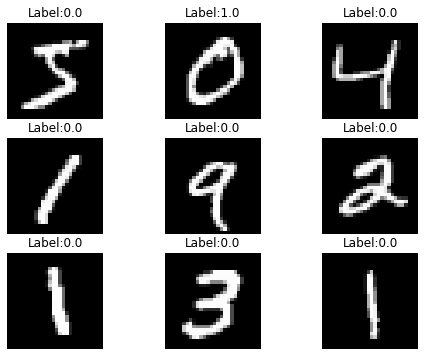

In [ ]:
num_images = 9 #choose a square number
factor = np.int(np.sqrt(num_images))
fig, ax =plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 #take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*factor
  for j in range(factor):
    ax[i,j].imshow(x_train[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

## Baeline Models

1. Count the number of samples per class
2. The model outputs the class which has highest number of samples
3. Then calculate the accuracy of the baseline model

In [ ]:
num_pos= len(np.where(y_train_0==1)[0])
num_neg = len(np.where(y_train_0==0)[0])
print(num_neg,num_pos)

54077 5923


In [ ]:
base_clf =DummyClassifier(strategy='most_frequent')
base_clf.fit(x_train,y_train_0)
print('Train accuracy:{0:.2f}'.format(base_clf.score(x_train,y_train_0)))
print('Testing accuracy:{0:.2f}'.format(base_clf.score(x_test,y_test_0)))

Train accuracy:0.90
Testing accuracy:0.90


The reason is obvious. the model would have predicted 54077 sample correctly just by outputting 0 for all the input samples. Therefore the accuracy will be $\frac{54077}{60000}$=90.12%

## Logistic Regression Model

Can use SGDClassifier() as Logistic Regression Model putting `loss=log`
- create instant of binary_classifier(bin_sgd_clf) and call the `fit` method to train the model
- Let is use the fit method of SGDClassifier() to plot the iteration vs loss curve(Of course, we could use the partial_fit() method as well)
- Therefore, to capture the loss for each iterations during the training we aet the paraeters war_start+True and max_iter=1.

### Training without regularization
- Set `eta0=0.01, learning_rate='constant'` and `alpha=0`

In [ ]:
bin_sgd_clf = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)
Loss=[]
iterations=100
for i in range(iterations):
  bin_sgd_clf.fit(x_train, y_train_0)
  y_pred= bin_sgd_clf.predict_proba(x_train)
  Loss.append(log_loss(y_train_0,y_pred))

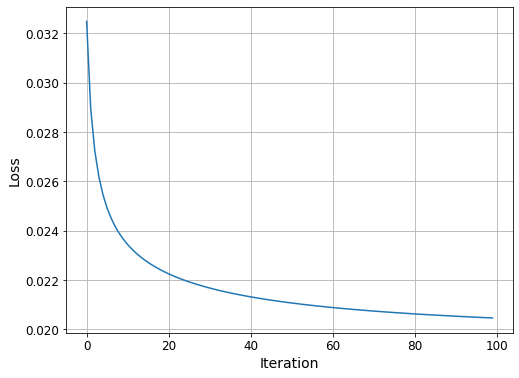

In [ ]:
plt.figure()
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
print('Training Accuracy:', bin_sgd_clf.score(x_train,y_train_0))
print('Test accuracy: ', bin_sgd_clf.score(x_test,y_test_0))

Training Accuracy: 0.99395
Test accuracy:  0.9919


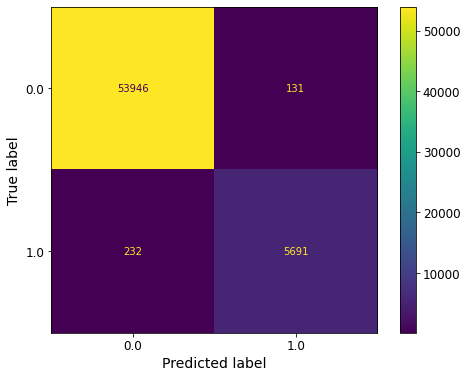

In [ ]:
y_hat_train_0 = bin_sgd_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g')
plt.show()

In [ ]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



Do cross validation to check for the generalization ability of the model

In [ ]:
estimator = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=100,
                            warm_start=False,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)

In [ ]:
cv_bin_clf = cross_validate(estimator,x_train,y_train_0,cv=5,
                            scoring=['precision','recall','f1'],
                            return_train_score=True,
                            return_estimator=True)
pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729)],
 'fit_time': array([1.92287016, 1.64436531, 1.81410074, 1.47704554, 1.23154688]),
 'score_time': array([0.07941985, 0.04156756, 0.04025602, 0.0403378 , 0.041049  ]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.9

Logoistic regression performing better than perceptron

In [ ]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_
print('Dimension of Weights w:{0}'.format(weights.shape))
print('Bias: {0}'.format(bias))


Dimension of Weights w:(1, 784)
Bias: [-4.89282893]


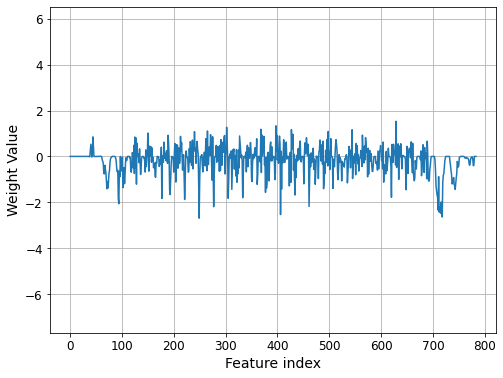

In [ ]:
plt.figure()
plt.plot(np.arange(0,784),weights[0,:])
plt.grid(True)
plt.xlabel('Feature index')
plt.ylabel('Weight Value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.show()

- It is interesting to observe how many weight values are exactly zero
- Those feautes contribute nothing in the classification.

In [ ]:
num_zero_w= weights.shape[-1]-np.count_nonzero(weights)
print('Number of weights with value zero:%f'%num_zero_w)

Number of weights with value zero:67.000000


- From the above plot it is clear that regularization is not required

### Training with regularization

In [ ]:
bin_sgd_clf_l2 = SGDClassifier(loss='log',
                            penalty='l2',
                           
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0.001,
                            learning_rate='constant',
                            random_state=1729)
Loss=[]
iterations=100
for i in range(iterations):
  bin_sgd_clf_l2.fit(x_train, y_train_0)
  y_pred= bin_sgd_clf_l2.predict_proba(x_train)
  Loss.append(log_loss(y_train_0,y_pred))

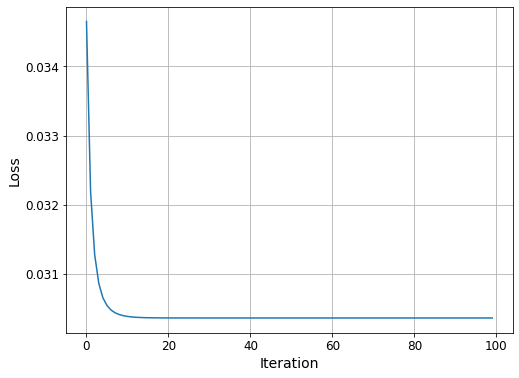

In [ ]:
plt.figure()
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_
print('Dimension of Weights w:{0}'.format(weights.shape))
print('Bias: {0}'.format(bias))

Dimension of Weights w:(1, 784)
Bias: [-4.43002876]


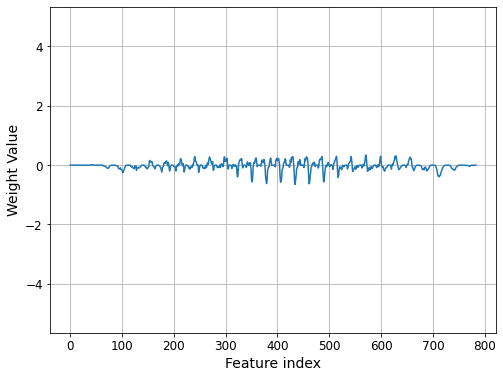

In [ ]:
plt.figure()
plt.plot(np.arange(0,784),weights[0,:])
plt.grid(True)
plt.xlabel('Feature index')
plt.ylabel('Weight Value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.show()

In [ ]:
num_zero_w= weights.shape[-1]-np.count_nonzero(weights)
print('Number of weights with value zero:%f'%num_zero_w)

Number of weights with value zero:67.000000


In [ ]:
print('Training Accuracy:', bin_sgd_clf.score(x_train,y_train_0))
print('Test accuracy: ', bin_sgd_clf.score(x_test,y_test_0))

Training Accuracy: 0.99395
Test accuracy:  0.9919


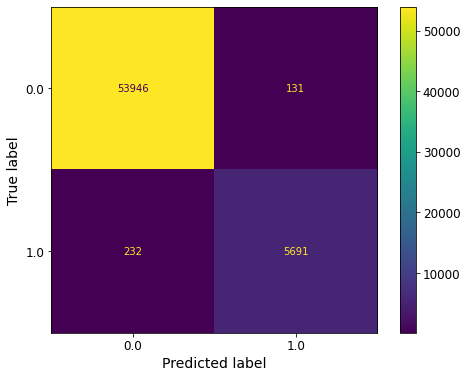

In [ ]:
y_hat_train_0 = bin_sgd_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g')
plt.show()

In [ ]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



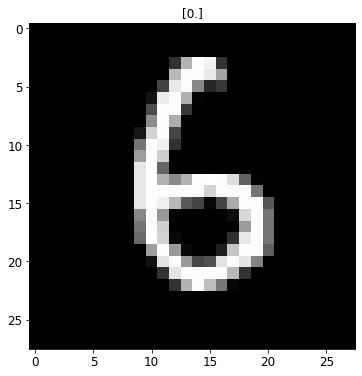

In [ ]:
index=21 #try some other index
plt.imshow(x_test[index,:].reshape(28,28),cmap='gray')
pred = bin_sgd_clf.predict(x_test[index].reshape(1,-1))
plt.title(str(pred))
plt.show()

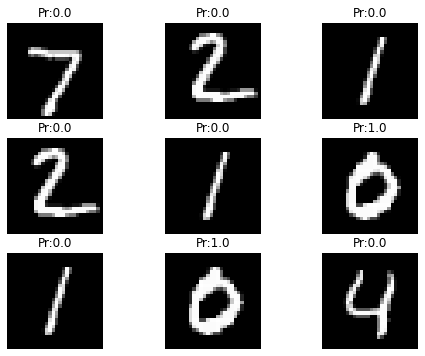

In [ ]:
y_hat_test_0 =bin_sgd_clf.predict(x_test)
num_images=9
factor =np.int(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+i
  for j in range(factor):
    ax[i,j].imshow(x_test[index+j].reshape(28,28),cmap='gray') #we should not use x_train with dummy
    ax[i,j].set_title('Pr:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

In [ ]:
indx_0=np.where(y_test_0==1)

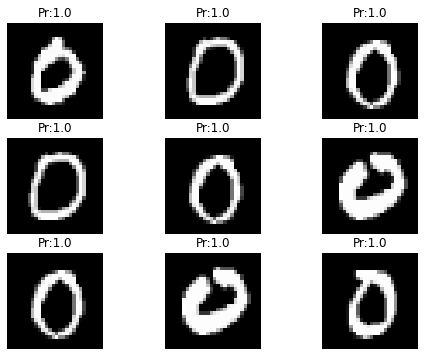

In [ ]:
zeroImgs =x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images=9
factor =np.int(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+i
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray') #we should not use x_train with dummy
    ax[i,j].set_title('Pr:{0}'.format(str(zeroLabls[index+j])))
    ax[i,j].set_axis_off()

### Hyper parameter tuning

In [ ]:
lr_grid =loguniform(1e-2,1e-1)

In [ ]:
print(lr_grid.rvs(3,random_state=42))

[0.02368864 0.0892718  0.05395031]


In [ ]:
estimator = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)

In [ ]:
scores = RandomizedSearchCV(estimator,
                            param_distributions={'eta0':lr_grid},
                            cv=5,
                            scoring=['precision','recall','f1'],
                            n_iter=5,
                            refit='f1'
                            )

In [ ]:
scores.fit(x_train,y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=1729,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa31981a610>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [ ]:
pprint(scores.cv_results_)

{'mean_fit_time': array([0.41034718, 0.35282321, 0.30788755, 0.30948806, 0.30651169]),
 'mean_score_time': array([0.05731235, 0.04613137, 0.04137568, 0.04128866, 0.04123073]),
 'mean_test_f1': array([0.95383975, 0.94148246, 0.94869555, 0.95090017, 0.95474878]),
 'mean_test_precision': array([0.96136672, 0.93597638, 0.94998271, 0.9540212 , 0.96640269]),
 'mean_test_recall': array([0.94682062, 0.94851138, 0.94834146, 0.94850966, 0.94361173]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                   0.05395030966670228, 0.039687933304443715,
                   0.01432249371823025],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.02368863950364078},
            {'eta0': 0.08927180304353625},
            {'eta0': 0.05395030966670228},
            {'eta0': 0.039687933304443715},
            {'eta0': 0.01432249371823025}],
 'rank_test_f1': array([2, 5, 4, 3, 1], dtype=int32),


In [ ]:
best_bin_clf =scores.best_estimator_

In [ ]:
y_hat_train_best_0=best_bin_clf.predict(x_train)

In [ ]:
print(classification_report(y_train_0,y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



### Classification Report

**Precision-Recall Tradeoff**

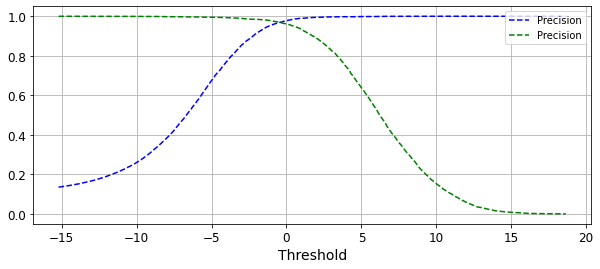

In [ ]:
y_scores = bin_sgd_clf.decision_function(x_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0,y_scores)
plt.figure(figsize=(10,4))
plt.plot(thresholds, precisions[:-1], "b--",label="Precision")
plt.plot(thresholds,recalls[:-1],"g--",label="Precision")
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

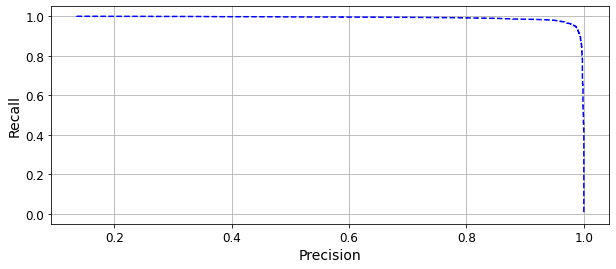

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(precisions[:-1], recalls[:-1],"b--")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

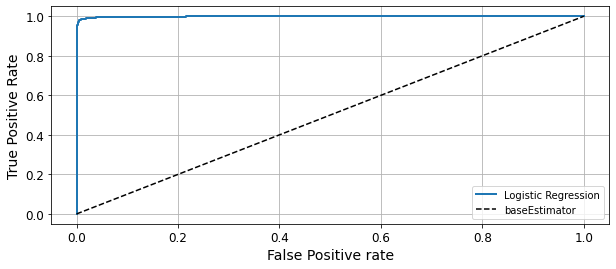

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr,tpr, linewidth=2,label='Logistic Regression')
plt.plot([0,1],[0,1],'k--',label='baseEstimator')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
auc= roc_auc_score(y_train_0,y_scores)
print('AUC: %.3f'%auc)

AUC: 0.998


## Logistic Regression- using Module

- We can also train classifier by solving a set of equations obatined by setting the derivative of loss wr.t weight to 0
- These are not linear equations and therefore we need a different set of solvers
- Sklearn uses solvers like `liblinear`,`newton-cg`,`sag`,`sags` and `lbfgs` to find the optimal weights
- Regularization is applied by default
- PArameters:
> `LogisticRegression(penalty='l2',*,daul=False,tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_State=None, solver='lbfgs',max_iter=100, multi_class='auto',verbose=0,warm_start=False,n_jobs=None, l1_ratio=None)
`

-Note some tof the important defualt parameters:
  - regularization: `penalty='l2'`
  - regularization rate: `C=1`
  - Solver:`solver='lbfgs'`

- Let's implement `LogisticRegression()` **without regularization** by setting the parameter C=$ \infty $. Therefore, we may expect preformance close to `SGDClassifier` without regularization.

### Training without regularization
- Step:1 Instantiate a pipeline object with two stages:
  - First stage contains MinMaxScaler for scaling the input
  - The second stage contains a `LogisticRegression` classifier with the regularization rate `C=infinity`
- STEP:2 Train the pipeline with feature matrix x_train and label vector y_Train_0

In [ ]:
pipe_logit = make_pipeline(MinMaxScaler(),LogisticRegression(random_state=1729,
                                                             solver='lbfgs',
                                                             C=np.infty))
pipe_logit.fit(x_train,y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

### Hyperparameter search

#### with`GridSearchCV`

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

grid_Cs = [0,1e-4,1e-3,1e-3,1e-1,1.0,10.0,100.0]
scaler = MinMaxScaler()
logreg = LogisticRegression(C=1.0,random_state=1729)
pipe = Pipeline(steps=[("scaler",scaler),("logistic",logreg)])
pipe_logit_cv = GridSearchCV(pipe,
                             param_grid={"logistic__C":grid_Cs},
                             scoring='f1')
pipe_logit_cv.fit(x_train,y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.001, 0.1, 1.0,
                                         10.0, 100.0]},
             scoring='f1')

In [ ]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

In [ ]:
pipe_logit_cv.best_score_

0.9579654953103655

In [ ]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

#### With `LogiticRegressionCV`

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
estimator = LogisticRegressionCV(cv=5, scoring='f1',random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(),estimator)
logit_cv.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

### Performance Evaluation

Let's evaluate performance of 3 different regression classifiers:
- Logistic Regression without regularization
- Best logistic regression classifier found through `GridSearchCV`
- Best classifier found through `LogisticRegressionCV`
> Not that `GridSearchCV` and `LogisticRegressionCV` by defualt refit the classifier for the best hyperparameter values

#### Precision, recall and f1 score

In [ ]:
lr_y_hat_0 = pipe_logit.predict(x_test)
lr_gs_y_hat_0 = pipe_logit_cv.best_estimator_.predict(x_test)
lr_cv_y_hat_0 = logit_cv.predict(x_test)

In [ ]:
precision_lr= precision_score(y_test_0,lr_y_hat_0)
recall_lr = recall_score(y_test_0,lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0,lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0,lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)


In [ ]:
print(f"LogReg: preicsion = {precision_lr}, recall={recall_lr}")
print(f"GridSearchCV: preicsion = {precision_lr_gs}, recall={recall_lr_gs}")
print(f"LogRegCV: preicsion = {precision_lr_cv}, recall={recall_lr_cv}")

LogReg: preicsion = 0.9515151515151515, recall=0.9612244897959183
GridSearchCV: preicsion = 0.9564336372847011, recall=0.963265306122449
LogRegCV: preicsion = 0.9546370967741935, recall=0.9663265306122449


#### Using PR Curve

In [ ]:
y_scores_lr= pipe_logit.decision_function(x_test)
precision_lr, recalls_lr, threshold_lr = precision_recall_curve(
    y_test_0, y_scores_lr
)
y_scores_lr_gs= pipe_logit_cv.decision_function(x_test)
precision_lr_gs, recalls_lr_gs, threshold_lr_gs = precision_recall_curve(
    y_test_0, y_scores_lr_gs
)
y_scores_lr_cv= logit_cv.decision_function(x_test)
precision_lr_cv, recalls_lr_cv, threshold_lr_cv = precision_recall_curve(
    y_test_0, y_scores_lr_cv
)

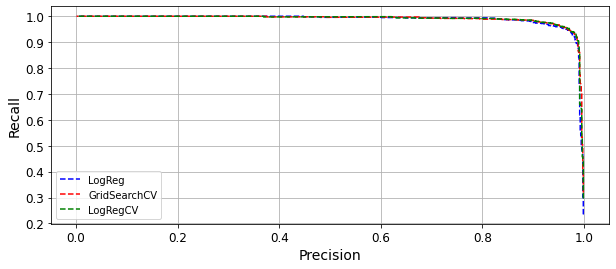

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(recalls_lr[:-1],precision_lr[:-1], "b--",label="LogReg")
plt.plot(recalls_lr_gs[:-1],precision_lr_gs[:-1], "r--",label="GridSearchCV")
plt.plot(recalls_lr_cv[:-1],precision_lr_cv[:-1], "g--",label="LogRegCV")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

In [ ]:
from sklearn.metrics import auc

auc_lr =auc(recalls_lr[:-1],precision_lr[:-1])
auc_lr_gs =auc(recalls_lr_gs[:-1],precision_lr_gs[:-1])
auc_lr_cv =auc(recalls_lr_cv[:-1],precision_lr_cv[:-1])

In [ ]:
print(f"AUC-PR for logistic regression:{auc_lr}")
print(f"AUC-PR for grid search:{auc_lr_gs}")
print(f"AUC-PR for logistic regression Cv:{auc_lr_cv}")

AUC-PR for logistic regression:0.9871337497759658
AUC-PR for grid search:0.9886520703587929
AUC-PR for logistic regression Cv:0.9886315347402387


#### Confusion Matrix

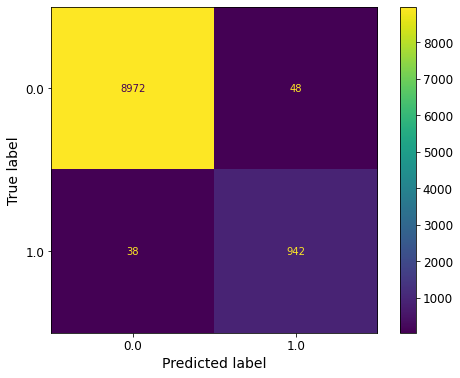

In [ ]:
cm_display =ConfusionMatrixDisplay.from_predictions(y_test_0,lr_y_hat_0, values_format='.5g')
plt.show()

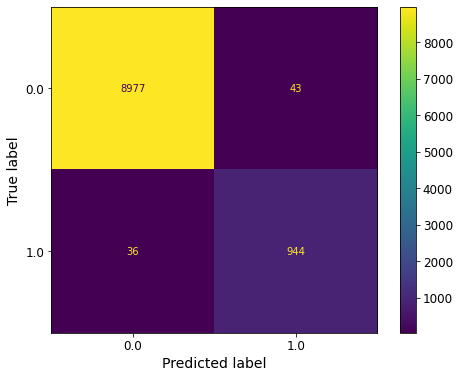

In [ ]:
cm_display =ConfusionMatrixDisplay.from_predictions(y_test_0,lr_gs_y_hat_0, values_format='.5g')
plt.show()

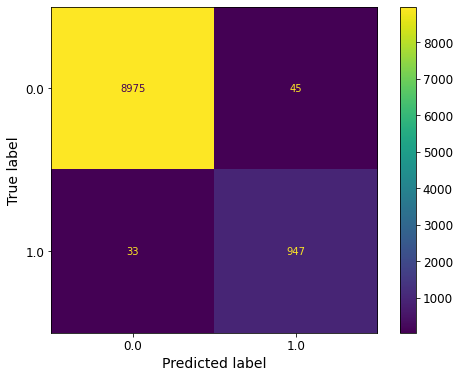

In [ ]:
cm_display =ConfusionMatrixDisplay.from_predictions(y_test_0,lr_cv_y_hat_0, values_format='.5g')
plt.show()

## Ridge Classifier
- Ridge classifier casts the problem as least square classification and finds the optimal weight using some matrix decomposition technique such as SVD
- To train the ridge classifier, the labels should be y $\in$ {+1,-1}
- The classifier also by default implements L@ regularization. However, we first implement it without regularization by setting `alpha=0`

In [ ]:

#initialize new variables names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train=='0')

y_train_0[indx_0]=1
indx_0=np.where(y_test=='0')
y_test_0[indx_0]=1

> `RidgeClassifier(alpha=1.0,*, fit_intercept=True, normalize='deprecated',copy_X=True, max_iter=Npne, tol=0.001, class_weight=None, solver='auto', positive=False, random_state=None)`
- Note the parameter `normalize` is deprecated

In [ ]:
estimator = RidgeClassifier(normalize=False, alpha=0)
pipe_ridge = make_pipeline(MinMaxScaler(),estimator)
pipe_ridge.fit(x_train,y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])

In [ ]:
y_hat_test_0 = pipe_ridge.predict(x_test)
print(classification_report(y_test_0,y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.95      0.87      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.93      0.95     10000
weighted avg       0.98      0.98      0.98     10000



### Cross validation

In [ ]:
cv_bin_ridge_clf = cross_validate(
    pipe_ridge, x_train, y_train_0,cv=5,
    scoring=['precision','recall','f1'],
    return_train_score=True,
    return_estimator=True
)
pprint(cv_bin_ridge_clf)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])],
 'fit_time': array([17.88383245, 19.73283291, 19.26762128, 20.16257977, 12.66761255]),
 'score_time': array([0.15993786, 0.15832305, 0.17716956, 0.18541408, 0.198632  ]),
 'test_f1': array([0.90710859, 0.90917108, 0.92334802, 0.904     , 0.90892857]),
 'test_preci

In [ ]:
best_estimator_id = np.argmax(cv_bin_ridge_clf['train_f1']);best_estimator_id

2

In [ ]:
best_estimator = cv_bin_ridge_clf['estimator'][best_estimator_id]

In [ ]:
y_hat_test_0 = best_estimator.predict(x_test)
print(classification_report(y_test_0,y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99      9020
         1.0       0.95      0.90      0.93       980

    accuracy                           0.99     10000
   macro avg       0.97      0.95      0.96     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
models = (pipr_sgd, pipe_sgd_12, pipe_logit, pipe_ridge)
titles = ('sgd','regularized sgd','logit','ridge')
plt.figure(figsize=(4,4))
plt.subplots(2,2)
for i in range(0,4):
  w=models[i][1].coef_
  w_matrix =w.reshape(28,28)
  w_matrix[w_matrix<0]=0 #just set the value less than zero to zero
  plt.subplot(2,2,i+1)
  plt.imshow(w_matrix,cmap='gray')
  plt.title(titles[i])
  plt.axis('off')
  plt.grid(False)
fig.show()

## Multiclass Classifier(OneVsAll)

### Multiclass Logit with SGD

In [ ]:
estimator = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)
pipe_sgd_ovr = make_pipeline(MinMaxScaler(),estimator)

In [ ]:
Loss=[]
iterations=100
for i in range(iterations):
  pipe_sgd_ovr.fit(x_train, y_train)
  y_pred= pipe_sgd_ovr.predict_proba(x_train)
  Loss.append(log_loss(y_train,y_pred))

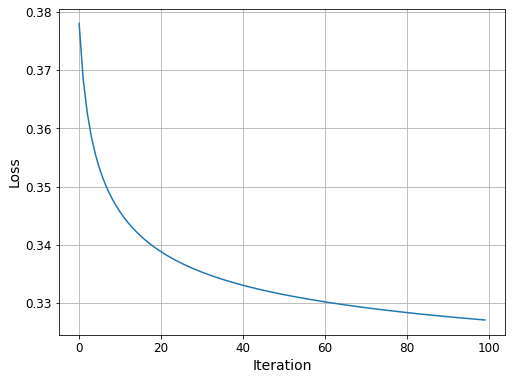

In [ ]:
plt.figure()
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
pipe_sgd_ovr[1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=1, random_state=1729, warm_start=True)

In [ ]:
pipe_sgd_ovr[1].coef_.shape

(10, 784)

In [ ]:
y_hat = pipe_sgd_ovr.predict(x_test);y_hat[:5]

array(['7', '2', '1', '0', '4'], dtype='<U1')

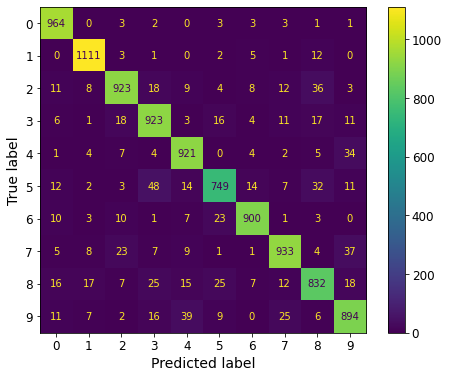

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='.5g')
plt.show()

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



### Multiclass LogisticRegression using Solver

In [ ]:
pipe_logit_ovr = make_pipeline(MinMaxScaler(),LogisticRegression(random_state=1729,
                                                             solver='lbfgs',
                                                             C=np.infty))
pipe_logit_ovr.fit(x_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

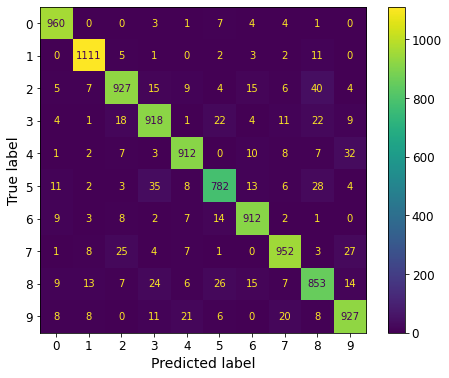

In [ ]:
y_hat =pipe_logit_ovr.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test,y_hat,values_format='.5g')

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



### Visualize the weight values

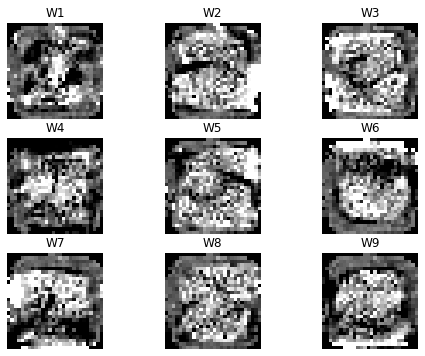

In [ ]:
W=pipe_logit_ovr[1].coef_
#normmalize
W=MinMaxScaler().fit_transform(W)
fig,ax = plt.subplots(3,3)
index=1
for i in range(3):
  for j in range(3):
    ax[i][j].imshow(W[index,:].reshape(28,28),cmap='gray')
    ax[i][j].set_title('W{0}'.format(index))
    ax[i][j].set_axis_off()
    index+=1

## Text classification with Naive Bayes classifier

In [1]:
# Data loading
from sklearn.datasets import fetch_20newsgroups

#Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

#Model/estimator
from sklearn.naive_bayes import MultinomialNB

#Pipeline/utility
from sklearn.pipeline import make_pipeline

#Model evaluation
from sklearn.metrics import ConfusionMatrixDisplay

#Plotting library
import matplotlib.pyplot as plt

### Dataset

In [2]:
data =fetch_20newsgroups()

In [3]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
categories = ['talk.religion.misc','soc.religion.christian','sci.space','comp.graphics']
train = fetch_20newsgroups(subset='train',categories=categories)
test = fetch_20newsgroups(subset='test',categories=categories)

In [5]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



### Data preprocessinf and modeling

In [7]:

model = make_pipeline(TfidfVectorizer(),MultinomialNB())

In [8]:
model.fit(train.data,train.target)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

### Model Evaluation

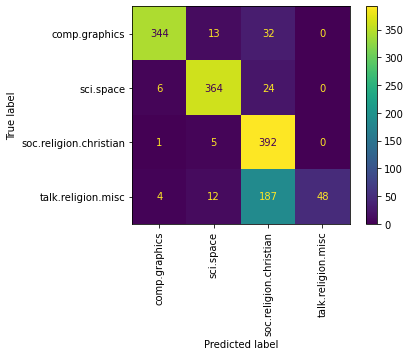

In [13]:
ConfusionMatrixDisplay.from_estimator(model,test.data,test.target,display_labels=test.target_names,xticks_rotation='vertical')
plt.show()

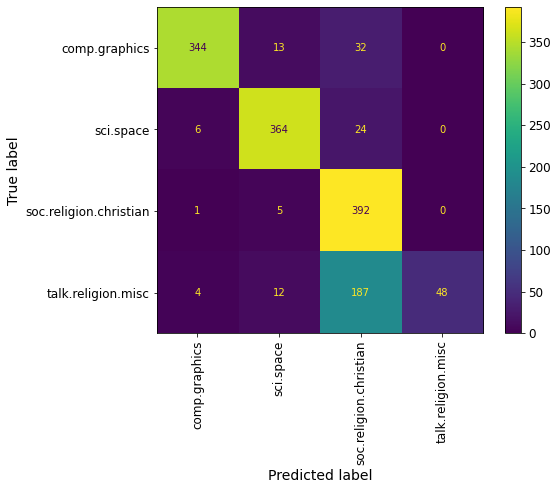

In [ ]:
ConfusionMatrixDisplay.from_estimator(model,test.data,test.target,display_labels=test.target_names,
                                      xticks_rotation='vertical')
plt.show()

In [14]:
def predict_category(s, train=train, model=model):
  pred = model.predict([s])
  
  return train.target_names[pred[0]]

In [15]:
predict_category('sending a payload to the ISS')

[1]


'sci.space'

In [ ]:
predict_category("i don't believe in god")

'soc.religion.christian'

In [ ]:
predict_category('determining the screen resolution')

'comp.graphics'

#Assignment

In [ ]:
X_pd,y_pd = fetch_openml('mnist_784',version=1,return_X_y=True)
X=X_pd.to_numpy()
y=y_pd.to_numpy()

In [ ]:
np.random.seed(42)

In [ ]:
x_train, x_test, y_train, y_test = X[:49000],X[49000:],y[:49000],y[49000:]

In [ ]:
y_train[-1]

'6'

In [ ]:
dig_6_idx =np.where(y_train=='6')[0]
dig_9_idx = np.where(y_train=='9')[0]
index = np.concatenate((dig_6_idx,dig_9_idx),axis=0)
x_train_69 = x_train[index,:]
y_train_69 = np.concatenate((np.ones(len(dig_6_idx)), np.zeros(len(dig_9_idx))))
from sklearn.utils import shuffle
x_train_69, y_train_69 =shuffle(x_train_69,y_train_69,random_state=1729)


In [ ]:
dig_6_idx =np.where(y_test=='6')[0]
dig_9_idx = np.where(y_test=='9')[0]
index = np.concatenate((dig_6_idx,dig_9_idx),axis=0)
x_test_69 = x_test[index,:]
y_test_69 = np.concatenate((np.ones(len(dig_6_idx)), np.zeros(len(dig_9_idx))))
from sklearn.utils import shuffle
x_test_69, y_test_69 =shuffle(x_test_69,y_test_69,random_state=1729)

In [ ]:
np.sum(y_train_69)

4855.0

In [ ]:
np.sum(y_test_69)

2021.0

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_69Tf = scaler.fit_transform(x_train_69)

In [ ]:
print('Mean of 0th sample',np.mean(x_train_69Tf[0,:]))
print('Mean of 0th feature',np.mean(x_train_69Tf[:,0]))
print('Std of 0th sample',np.std(x_train_69Tf[0,:]))
print('Std of 0th feature',np.std(x_train_69Tf[:,0]))

Mean of 0th sample 0.08128379559427823
Mean of 0th feature 0.0
Std of 0th sample 0.7358823226037738
Std of 0th feature 0.0


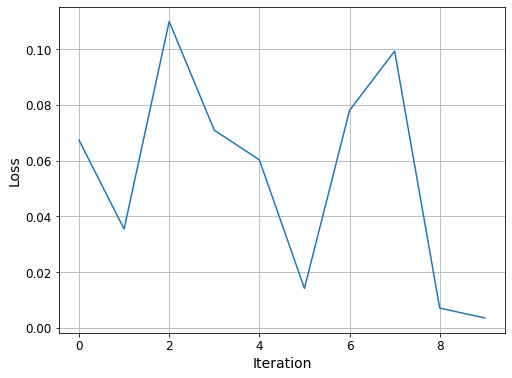

In [ ]:
estimator = SGDClassifier(loss='log',
                          penalty='l2',
                          max_iter=1,
                          eta0=0.01,
                          warm_start=True,
                          alpha=0,
                          learning_rate='constant',
                          random_state=10
                          )
pipe_sgd = make_pipeline(estimator)
Loss=[]
for i in range(10):
  pipe_sgd.fit(x_train_69,y_train_69)
  y_hat_69 = pipe_sgd.predict_proba(x_train_69)
  Loss.append(log_loss(y_train_69,y_hat_69))
plt.figure()
plt.plot(np.arange(10),Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
data =fetch_20newsgroups()

In [ ]:
tf = TfidfVectorizer()
tf_vector = tf.fit_transform(data.data)

In [ ]:
tf_vector.shape

(11314, 130107)

In [ ]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
data.target

array([7, 4, 4, ..., 3, 1, 8])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(tf_vector, data.target,test_size=0.3,random_state=0)

In [ ]:
mb =MultinomialNB()
mb.fit(x_train,y_train)

MultinomialNB()

In [ ]:
from sklearn.metrics import r2_score
